# Deterministic optimisation (using the fluid model)

$See PSOR Paper repo for cleaner version with just 3 objective funcs, here we allow several obj funcs to be analysed, including those with the analytical queueing model$

Here we optimise over several deterministic objective functions evaluated using the fluid flow model. 

* [This link](https://github.com/grahamburgess3/homeless_services/blob/main/notes/2024-02-19-Optim_Formulations_Specific/Optim-Formulations.pdf) gives the details of the suggested formulations.
* [This link](https://github.com/grahamburgess3/homeless_services/blob/main/08_fluid_flow_model.ipynb) details the workings of the fluid flow model.

The goal is to establish which features of a problem formulation best capture the aspects of the real-world problem we are interested in modeling. 

We start by giving an illustrative example of the dynamics of the unsheltered queue $u_t$ given by our fluid model, given inputs for $X_0, \mu$ and $\lambda_t, h_t, s_t$ for all $t \in \{1,...,T\}$ which we take directly from the simulation model of Singham et al (2023). The number unsheltered does not decrease (as it does in the simulation model) since the house building process in the fluid model is a continuous process over the course of each year, whereas in the simulation model the house building is done upfront at two-month intervals, starting at time $t=0$.

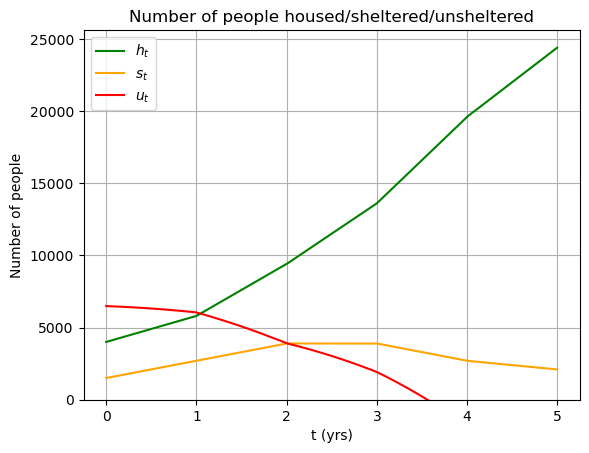

In [1]:
import json
import deterministic_optimisation as do
import fluid_flow_model as fl
import matplotlib.pyplot as plt
import math
import numpy as np

with open('data_as_is.json') as json_file:
    data_as_is = json.load(json_file)

T_a = 5*365
T_b = 0
solution = {}

# data x 100 (since the simulation paper divides the numbers by 100)
data_as_is['initial_capacity']['housing'] = data_as_is['initial_capacity']['housing']*100
data_as_is['initial_capacity']['shelter'] = data_as_is['initial_capacity']['shelter']*100
data_as_is['initial_demand'] = data_as_is['initial_demand']*100
data_as_is['arrival_rates'] = [x*100/365 for x in data_as_is['arrival_rates']]
solution['housing'] = [data_as_is['initial_capacity']['housing'] + sum([x*100 for x in data_as_is['build_rates']['housing']][0:i]) for i in range(1,len(data_as_is['build_rates']['housing'])+1)]
solution['shelter'] = [data_as_is['initial_capacity']['shelter'] + sum([x*100 for x in data_as_is['build_rates']['shelter']][0:i]) for i in range(1,len(data_as_is['build_rates']['shelter'])+1)]

# modeling
model = fl.FluidFlowModel(data_as_is, solution, T_a, T_b)
T = [i for i in range(T_a+T_b)]
model.analyse(T)

# plotting
# general plotting
fig, ax = plt.subplots()
ymax = max(model.h + model.s + model.u)

# plot optimal solution
x = [t/365 for t in range(T_a+T_b)]
ax.plot(x, model.h, color = 'green')
ax.plot(x, model.s, color = 'orange')
ax.plot(x, model.u, color = 'red')
ax.set(xlabel='t (yrs)', ylabel='Number of people',
       title='Number of people housed/sheltered/unsheltered')
ax.legend(["$h_t$", "$s_t$", "$u_t$"], loc="upper left")
ax.grid()
ax.set_ylim(0,ymax*1.05)

# general
plt.show()

####  $\Phi_0$ : linear penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t) + c*E[sh(t)]])
    # s.t. total budget constraint
    #      annual minimum build constraint

As shown below, an optimal solution here would spend **all surplus budget in the first year**, on either housing or shelter.

------- Optimal solution -------
Housing capacity at end of each year: [4500.0, 5000.0, 5500.0, 6000.0, 6500.0]
Shelter capacity at the end of each year: [2000.0, 2500.0, 3000.0, 3500.0, 4000.0]
Optimal objective val: 27695.47


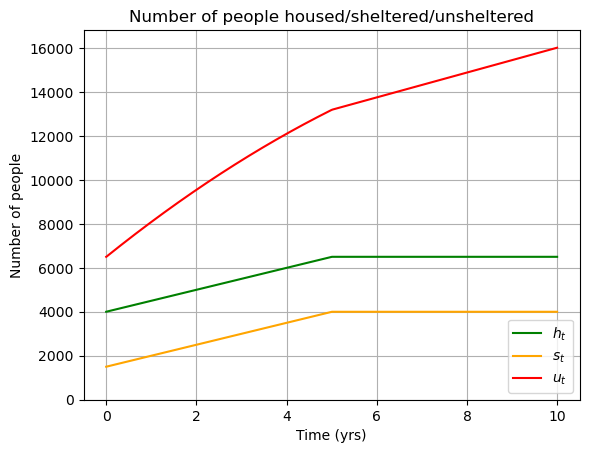

In [2]:
# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [10.0]*5 + [6.0]*5,
        'budget' : 200000000.0, # in dollars
        'costs_accomm' : {'housing' : 30000.0, 'shelter' : 10000.0}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'T_a' : 5*365, # in days: modelling and building
                    'T_b' : 5*365, # in days: extra modelling following all building
                    'timestep' : 1/365, # in years
                    'model' : do.FluidModel}

# Set up problem and solve
problem0 = do.Phi1(data, modeling_options, 'phi1', c=0.5)
problem0.solve('glpk')

####  $\Phi_2$ : quadratic penalty unsheltered Q and sheltered Q
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      annual minimum build constraint

Non-trivial solutions are obtained with a quadratic objective function which discourages the spending of all surplus budget on one type of accommodation and balances the unshelterd and sheltered queues. We note here that: 

* **Shelter** quickly reduces the unsheltered queue, at the expense of a large **sheltered** population.
* **Housing** gives long-term relief to the system, with an initial large **unsheltered** population.  

The data below is based upon the system as it has previously been modelled by Singham et al (2023) We have a decision horizon of 5 years and a modelling horizon of 10 years. During the second half of the model run, no new accommodation is built, but we have a reduced arrival rate. We enforce a baseline building rate for both housing and shelter ($500 \text{units}$), giving a surplus budget of $100 \text{ million USD}$. We here choose a value of $c = 0.25$, the weighting on the shelterd penalty, but experimentation has showed that the results are very sensitive to this parameter. Below we choose to spend most (but not all) of our extra budget on housing in the first year. .

In [2]:
# Set data for system behaviour
data = {'initial_capacity' : {'housing':4000, 'shelter':1500},
        'initial_demand' : 12000, # initial number of people in system
        'service_mean' : {'housing': 4.0, 'shelter': 0.0}, # in years
        'arrival_rates' : [3650.0]*5 + [2190.0]*5,
        'budget' : 200000000, # in dollars
        'costs_accomm' : {'housing' : 30000, 'shelter' : 10000}, # cost in dollars per unit
        'baseline_build' : 500} # how many housing units and shelter units we must build at least each year

# Set modeliing options
modeling_options = {'horizon_model' : 10, # in years
                    'horizon_decision' : 5, # in years
                    'timestep' : 1/365, # in years
                    'model' : do.FluidModel}

# Set up problem and solve
problem2 = do.Phi2(data, modeling_options, 'phi2', c=0.25)
problem2.solve('ipopt')

NameError: name 'do' is not defined

####  $\Phi_3$ : Add shape constraints
    # min TimeAvg(E[unsh(t)^2] + c*E[sh(t)^2])
    # s.t. total budget constraint
    #      shape constraint on house building rate: positive and non-decreasing
    #      shape constraint on shelter building rate: positive and non-decreasing then negative. 

We here add shape constraints to reflect the fact that: 

* A five-year budget should be spread out across that horizon rather than being used predominantly in the first year.
* We would like the house building rate to at least stay the same over time, or even ramp up. 
* We would like to encourage a negative shelter build rate towards the end of the horizon to allow the 'conversion' of shelter to housing.

When optimising over the quadratic objective function, we find an optimal solution which has the following features: 

* A constant house building rate over the decision horizon. 
* An initial ramp up of shelter is able to bring the unshelterd queue down to as low as $4000 \text{ people}$.
* Subsequent conversion of shelter to housing makes it affordable to build sufficient housing to obtain a service rate in the long run which is greater than the arrival rate of $2500 \text{ arrivals per year}$.
* The price to pay for conversion is an increased unsheltered population in the short term. 

------- Optimal solution -------
Number of housing units to build annually: [1231.0, 1231.0, 1231.0, 1231.0, 1231.0]
Number of shelter units to build annually: [2486.2, 2486.2, 2486.2, -2230.59, -3693.0]
Proportion of total budget spent on housing: ['18%', '18%', '18%', '18%', '18%']
Proportion of total budget spent on shelter: ['12%', '12%', '12%', '-11%', '-18%']
Optimal objective val: 50230457.06


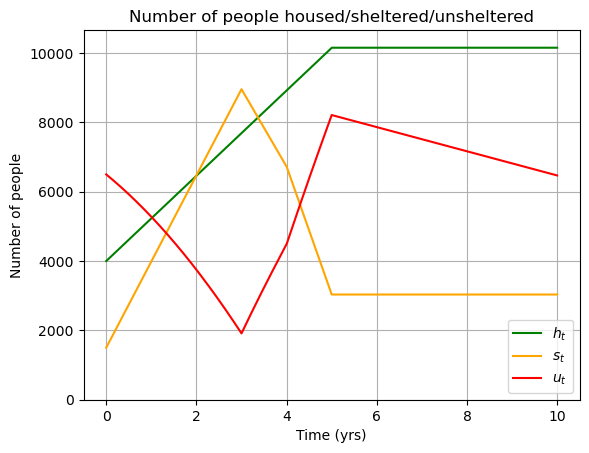

In [3]:
# Set up problem and solve
problem3 = do.Phi3(data, modeling_options, 'phi3', c=0.5, shelter_mode = 3)
problem3.solve('ipopt')

#### Comparison of results (Phi 2 and Phi 3)

In [4]:
import pandas as pd
data = [['$\Phi_0$']+['Housing']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem2.problem.costs_accomm['housing'])/(problem2.problem.budget)) + ')' for x in problem2.h_opt],
        ['']+['Shelter']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem2.problem.costs_accomm['shelter'])/(problem2.problem.budget)) + ')' for x in problem2.s_opt],
       ['$\Phi_1$']+['Housing']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem3.problem.costs_accomm['housing'])/(problem3.problem.budget)) + ')' for x in problem3.h_opt],
        ['']+['Shelter']+[str(int(round(x,0))) + ' (' + '{:.0%}'.format((x*problem3.problem.costs_accomm['shelter'])/(problem3.problem.budget)) + ')' for x in problem3.s_opt]]
df = pd.DataFrame(columns=['Problem','Building Type','Year 1','Year 2','Year 3','Year 4','Year 5'], data=data)
df.style.hide()

Problem,Building Type,Year 1,Year 2,Year 3,Year 4,Year 5
$\Phi_0$,Housing,3293 (49%),500 (7%),500 (7%),500 (7%),500 (7%)
,Shelter,2121 (11%),500 (2%),500 (2%),500 (2%),500 (2%)
$\Phi_1$,Housing,1231 (18%),1231 (18%),1231 (18%),1231 (18%),1231 (18%)
,Shelter,2486 (12%),2486 (12%),2486 (12%),-2231 (-11%),-3693 (-18%)


####  $\Phi_4$ : Drop shape constraints - add annual budget constraints & time dependent weighting on shelter. 
    # min TimeAvg(E[unsh(t)^2]) + WeightedTimeAvg(E[sh(t)^2])
    # s.t. annual increasing budget constraint

Instead of shape constraints, we here add an annual increasing budget to reflect the fact that a budget may typically be split across financial years, with more budget being available at later times. 

We include a time dependent weighting on the shelter penalty to reflect the fact that initially shelter is an acceptable short-term solution, but not in the long-term. 

Here we work with a weight function $w(t)$ which is linear and non-decreasing w.r.t time. We require the $w(t)$ function to reach a maximum of $\frac{1}{horizon}$ since this is the constant weight by which we penalise the squared unsheltered queue. Therefore the gradient of $w(t)$ has a lower bound of $0$ and upper bound of $\frac{1}{horizon^2}$. Our choice of $m$ below must take a value between $0$ and $1$ and indicates the magnitude of the gradient of $w(t)$, $0$ being no gradient, $1$ being max possible gradient. 

When optimising over the quadratic objective function, we find an optimal solution which has the following features: 

* As a proportion of the annual budget, we have a house building rate which peaks in the first year (when the effect of new housing can have benefit over a long time period) and then again peaks in the fourth year (when the penalty on new shelter has increased). 
* The ramp up of shelter is slow since to build shelter early is less effective than building new housing early in the long run.
* The unsheltered population initially rises since housing is preferred over shelter, but then starts to come down as shelter ramps up and new housing takes effect. But sufficient housing has not been built in the long run so the service rate is less than the arrival rate and the unsheltered queue continues to grow. 

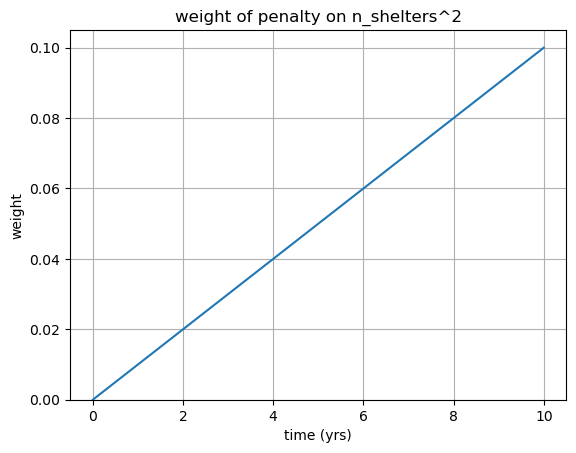

In [5]:
m = 1.0
weights = do.get_linear_weight_func(m, modeling_options['horizon_model'], modeling_options['timestep'])
do.plot_weight_func(weights, modeling_options['horizon_model'], modeling_options['timestep'])

In [6]:
# Set up problem and solve
problem = do.Phi4(data, modeling_options, 'phi4', c=weights, budget_props = [0.1, 0.15, 0.2, 0.25, 0.3]) # proportions must add to 1. 
problem.solve('ipopt')

TypeError: list indices must be integers or slices, not str